In [60]:
import numpy as np
import matplotlib.pyplot as plt

from new_fft import new_fft, new_ifft, new_fft2
from frac_fft import frac_fft
from pad import pad, adj_pad
from ppfft import ppfft
from onion_peeling import fast_compute_alpha, resample_row

# PPFFT improvement

In the original paper, a 2D FFT is done on the image, before applying 1D IFFT on the columns of the output. This can easily be replaced by a 1D FFT on the line of the input.

In [61]:
def ppfft_horizontal(a: np.ndarray) -> np.ndarray:
    """
    Pseudo-Polar Fast Fourier Transform on the basically horizontal lines.

    ## Parameters
    a : np.ndarray
        Input array of shape (n, n) where n is even.

    ## Returns
    y : np.ndarray
        Ouput array of shape (n+1, 2n+1).
    """
    n, _ = a.shape
    m = 2 * n + 1

    res = np.empty((n + 1, m), dtype=np.complex64)
    Id_hat = new_fft2(pad(a, new_shape=(n, m)))
    for k in range(m):
        q = Id_hat[:, k]
        ifft_q = new_ifft(q)
        pad_ifft_q = pad(ifft_q, (m,))
        frac_pad_ifft_q = frac_fft(pad_ifft_q, 2 * (k - n), n)
        adj_pad_frac_ifft_q = adj_pad(frac_pad_ifft_q, (n + 1,))
        res[:, k] = adj_pad_frac_ifft_q[::-1]

    return res

In [62]:
def new_ppfft_horizontal(a: np.ndarray) -> np.ndarray:
    """
    Pseudo-Polar Fast Fourier Transform on the basically horizontal lines.

    ## Parameters
    a : np.ndarray
        Input array of shape (n, n) where n is even.

    ## Returns
    y : np.ndarray
        Ouput array of shape (n+1, 2n+1).
    """
    n, _ = a.shape
    m = 2 * n + 1

    res = np.empty((n + 1, m), dtype=np.complex64)

    aux = new_fft(pad(a, new_shape=(n, m)))
    pad_aux = pad(aux, (m, m))

    for k in range(m):
        pad_ifft_q = pad_aux[:, k]
        frac_pad_ifft_q = frac_fft(pad_ifft_q, 2 * (k - n), n)
        adj_pad_frac_ifft_q = adj_pad(frac_pad_ifft_q, (n + 1,))
        res[:, k] = adj_pad_frac_ifft_q[::-1]

    return res

In [63]:
n = 10
im = np.random.rand(n, n)
print(np.allclose(new_ppfft_horizontal(im), ppfft_horizontal(im)))
print(np.max(np.abs(new_ppfft_horizontal(im) - ppfft_horizontal(im))))
n = 11
im = np.random.rand(n, n)
print(np.allclose(new_ppfft_horizontal(im), ppfft_horizontal(im)))
print(np.max(np.abs(new_ppfft_horizontal(im) - ppfft_horizontal(im))))

True
4.9303807e-32
True
0.0


# Selection of points in onion-peeling

We can try to find a pattern in the way points should be selected.

I we can't, we can precompute them (in the same way it is done for the Toeplitz matrices), since the indices only depend on $n$.

In [64]:
from onion_peeling import find_closest

In [65]:
def build_y(k, n):
    """
    -(n//2) < k < 0
    """
    half_n = n // 2
    m = 2 * n + 1

    y_ppfft = 8 * np.pi * k * np.arange(-half_n, half_n + 1) / (n * m)
    y_left = -4 * np.pi * np.arange(-half_n, k) / m
    y_right = 4 * np.pi * np.arange(-half_n, k) / m

    return np.concatenate((y_left, y_ppfft, y_right))

In [66]:
n = 10

for k in range(-(n // 2) + 1, 0):
    true_k = k + n // 2
    y = build_y(k, n)
    res = find_closest(y, n)
    print(res[true_k:-true_k] - true_k)

[ 0  1  2  4  5  6  8  9 10]
[ 0  2  3  5  7  8 10]
[ 0  2  5  8 10]
[ 0  5 10]


In [67]:
def new_find_closest(k, n):
    l = np.arange(k, -np.sign(k) - k, step=-np.sign(k))
    return n//2 + np.rint(- n * l / (2 * k)).astype(int)

In [68]:
for k in range(-(n // 2) + 1, 0):
    print(new_find_closest(k, n))

[ 0  1  3  4  5  6  7  9 10]
[ 0  2  3  5  7  8 10]
[ 0  3  5  7 10]
[ 0  5 10]


The behavior of the two methods is similar. The only difference is when a target point has two closest neighbors, in which case the previous method chooses the first one in the list, whereas the second method chooses the other. This should not have any influence on the onion-peeling method.

In [69]:
n = 1000
k = np.random.randint(-(n // 2) + 1, 0)
y = build_y(k, n)

In [70]:
%timeit find_closest(y, n)

11.4 ms ± 953 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [71]:
%timeit new_find_closest(k, n)

9.92 µs ± 910 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [72]:
n = 20
for k in range(-(n // 2) + 1, 0):
    print(np.max(np.abs(new_find_closest(k, n) - new_find_closest(-k, n))))

0
0
0
0
0
0
0
0
0


# Better initialization

$$
\forall k \in \llbracket - \frac{n}{2}, \frac{n}{2}\rrbracket, \, \widehat{I}_D(k, k) = \widehat{I}_v(2k, -\frac{n}{2}), 
\widehat{I}_D(k, -k) = \widehat{I}_h(2k, \frac{n}{2})

$$

In [73]:
def new_initialize(hori_ppfft, vert_ppfft):
    n = hori_ppfft.shape[0] - 1

    I_d = np.zeros(shape=(n + 1, n + 1), dtype=complex)

    I_d[0] = vert_ppfft[:, 0]  # x = -n/2
    I_d[-1] = vert_ppfft[::-1, -1]  # x = n/2
    I_d[:, 0] = hori_ppfft[:, 0]  # y = -n/2
    I_d[:, -1] = hori_ppfft[::-1, -1]  # y = n/2

    np.fill_diagonal(I_d, vert_ppfft[0, ::2])
    np.fill_diagonal(np.fliplr(I_d), vert_ppfft[-1, ::2])

    I_d[n // 2] = hori_ppfft[n // 2, ::2]
    I_d[:, n // 2] = vert_ppfft[n // 2, ::2]

    return I_d

In [74]:
def compute_true_Id(im):
    n = len(im)
    m = 2 * n + 1
    pad_im = pad(im, (m, m))
    return new_fft2(pad_im)[::2, ::2]

In [75]:
n = 100
im = np.random.rand(n, n)
hori, vert = ppfft(im)
true_Id = compute_true_Id(im)
init_Id = new_initialize(hori, vert)

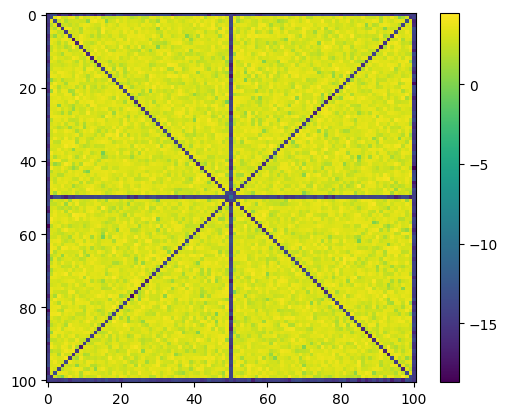

In [76]:
plt.imshow(np.log(np.abs(true_Id - init_Id)))
plt.colorbar()

Incorporate this is onion peeling, by not modifying these points.

In [77]:
def fast_recover_row_negative(k, y, indices, vert_ppfft, Id):
    """
    Recovers row  -(n//2) < k < 0 of Id.
    Id is modified in place.
    """
    n = vert_ppfft.shape[0] - 1
    half_n = n // 2
    true_k = k + half_n

    known_ppfft = vert_ppfft[:, 2 * k + n]
    known_ppfft = np.take(known_ppfft, indices)

    known_I_D_pos = Id[true_k, :true_k]

    known_I_D_neg = Id[true_k, -true_k:]

    known_samples = np.concatenate((known_I_D_pos, known_ppfft, known_I_D_neg))

    alpha = fast_compute_alpha(y, n, known_samples)

    res = resample_row(alpha)

    Id[true_k, true_k + 1 : n//2] = res[true_k + 1 : n//2]
    Id[true_k, n//2 + 1 : -true_k - 1] = res[n//2 + 1 : -true_k - 1]

    # Id[true_k, true_k:-true_k] = res[true_k:-true_k]


def fast_recover_row_positive(k, y, indices, vert_ppfft, Id):
    """
    Recovers row 0 < k < n//2 of Id.
    Id is modified in place.
    """
    n = vert_ppfft.shape[0] - 1
    half_n = n // 2
    true_k = k + half_n

    known_ppfft = vert_ppfft[:, 2 * k + n]
    known_ppfft = np.take(known_ppfft, indices)

    known_I_D_pos = Id[true_k, : (n - true_k)]

    known_I_D_neg = Id[true_k, (true_k - n) :]

    known_samples = np.concatenate((known_I_D_pos, known_ppfft[::-1], known_I_D_neg))

    alpha = fast_compute_alpha(y, n, known_samples)

    res = resample_row(alpha)

    Id[true_k, (n - true_k) + 1 : n//2] = res[(n - true_k) + 1 : n//2]
    Id[true_k, n//2 + 1 : true_k - n - 1] = res[n//2 + 1 : true_k - n - 1]

    # Id[true_k, (n - true_k) : (true_k - n)] = res[(n - true_k) : (true_k - n)]


def fast_recover_col_negative(k, y, indices, hori_ppfft, Id):
    """
    Recovers column -(n//2) < k < 0 of Id.
    Id is modified in place.
    """
    n = hori_ppfft.shape[0] - 1
    half_n = n // 2
    true_k = k + half_n

    known_ppfft = hori_ppfft[:, 2 * k + n]  # n + 1 elements
    known_ppfft = np.take(known_ppfft, indices)

    known_I_D_pos = Id[:true_k, true_k]

    known_I_D_neg = Id[-true_k:, true_k]

    known_samples = np.concatenate((known_I_D_pos, known_ppfft, known_I_D_neg))

    alpha = fast_compute_alpha(y, n, known_samples)

    res = resample_row(alpha)

    Id[true_k + 1 : n//2, true_k] = res[true_k + 1 : n//2]
    Id[n//2 + 1 : -true_k - 1, true_k] = res[n//2 + 1 : -true_k - 1]

    # Id[true_k:-true_k, true_k] = res[true_k:-true_k]


def fast_recover_col_positive(k, y, indices, hori_ppfft, Id):
    """
    Recovers column 0 < k < n//2 Id.
    Id is modified in place.
    """
    n = hori_ppfft.shape[0] - 1
    half_n = n // 2
    true_k = k + half_n

    known_ppfft = hori_ppfft[:, 2 * k + n]  # n + 1 elements
    known_ppfft = np.take(known_ppfft, indices)

    known_I_D_pos = Id[: (n - true_k), true_k]

    known_I_D_neg = Id[(true_k - n) :, true_k]

    known_samples = np.concatenate((known_I_D_pos, known_ppfft[::-1], known_I_D_neg))

    alpha = fast_compute_alpha(y, n, known_samples)

    res = resample_row(alpha)

    Id[(n - true_k) + 1 : n//2, true_k] = res[(n - true_k) + 1 : n//2]
    Id[n//2 + 1 : true_k - n - 1, true_k] = res[n//2 + 1 : true_k - n - 1]

    # Id[(n - true_k) : (true_k - n), true_k] = res[(n - true_k) : (true_k - n)]



In [78]:
def fast_onion_peeling(hori_ppfft, vert_ppfft):
    Id = new_initialize(hori_ppfft, vert_ppfft)
    n = hori_ppfft.shape[0] - 1
    m = 2 * n + 1
    half_n = n // 2

    for k in range(-(n // 2) + 1, 0):

        y_ppfft = 8 * np.pi * k * np.arange(-half_n, half_n + 1) / (n * m)
        indices = new_find_closest(k, n)
        y_ppfft = np.take(y_ppfft, indices)

        y_pos = -4 * np.pi * np.arange(-half_n, k) / m
        y_neg = 4 * np.pi * np.arange(-half_n, k)[::-1] / m

        y = np.concatenate((y_pos, y_ppfft, y_neg))

        fast_recover_row_negative(k, y, indices, vert_ppfft, Id)
        fast_recover_row_positive(-k, y, indices, vert_ppfft, Id)

        fast_recover_col_negative(k, y, indices, hori_ppfft, Id)
        fast_recover_col_positive(-k, y, indices, hori_ppfft, Id)

    return Id

In [79]:
im = plt.imread("Shepp_logan_240.png")
hori, vert = ppfft(im)
true_Id = compute_true_Id(im)

In [80]:
res = fast_onion_peeling(hori, vert)

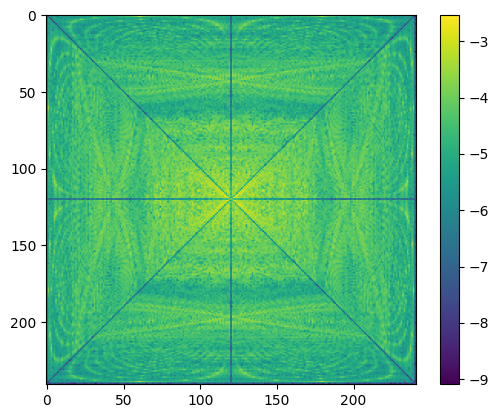

In [81]:
plt.imshow(np.log10(np.abs(true_Id - res)))
plt.colorbar()

# Precomputations

In [90]:
from scipy.linalg import solve_toeplitz, matmul_toeplitz

from pynufft import NUFFT

In [139]:
class InverseToeplitz:

    def __init__(self, col, row=None) -> None:
        """
        A Toeplitz matrix T is represented by:
        - its first column: col
        - its first row: row

        If row is not provided, it is assumed T is Hermitian.
        """
        self.col = col
        self.row = row

        self.x0 = None
        self.m1 = None
        self.m2 = None
        self.m3 = None
        self.m4 = None

        self.gohberg_semencul()

    def gohberg_semencul(self):
        """
        Compute the Gohberg-Semencul decomposition of T^{-1}
        """
        e0 = np.zeros_like(self.col)
        e0[0] = 1

        e1 = np.zeros_like(self.col)
        e1[-1] = 1

        if self.row is None:
            x = solve_toeplitz(self.col, e0)
            y = solve_toeplitz(self.col, e1)

        else:
            x = solve_toeplitz((self.col, self.row), e0)
            y = solve_toeplitz((self.col, self.row), e1)

        x_a = np.zeros_like(x)
        x_a[0] = x[0]

        x_b = np.zeros_like(x)
        x_b[1::] = x[:0:-1]

        y_a = np.zeros_like(y)
        y_a[0] = y[-1]

        y_b = np.zeros_like(y)
        y_b[1::] = y[:-1]

        self.x0 = x[0]
        self.m1 = (x, x_a)
        self.m2 = (y_a, y[::-1])
        self.m3 = (y_b, np.zeros_like(y))
        self.m4 = (np.zeros_like(x), x_b)

    def apply_inverse(self, vec):
        """
        Computes T^{-1} @ vec.
        """
        M1M2_v = matmul_toeplitz(self.m1, matmul_toeplitz(self.m2, vec))

        M3M4_v = matmul_toeplitz(self.m3, matmul_toeplitz(self.m4, vec))

        return (M1M2_v - M3M4_v) / self.x0
        

In [140]:
def precompute_onion_peeling(n):
    """
    Computes and stores:
    - all the Toeplitz inverses 
    - all the Nufft objects
    needed for the onion-peeling algorithm.
    """

    half_n = n // 2
    m = 2 * n + 1

    toeplitz_list = []
    nufft_list = []
    
    for k in range(-half_n + 1, 0):

        y_ppfft = 8 * np.pi * k * np.arange(-half_n, half_n + 1) / (n * m)
        indices = new_find_closest(k, n)
        y_ppfft = np.take(y_ppfft, indices)

        y_pos = -4 * np.pi * np.arange(-half_n, k) / m
        y_neg = 4 * np.pi * np.arange(-half_n, k)[::-1] / m

        y = np.concatenate((y_pos, y_ppfft, y_neg))

        c = np.einsum("lj->l", np.exp(-1j * np.arange(0, n)[:, None] * y[None, :]))

        toeplitz_list.append(InverseToeplitz(col=c))

        NufftObj = NUFFT()
        NufftObj.plan(om=-y[:, None], Nd=(n,), Kd=(2 * n,), Jd=(6,))
        nufft_list.append(NufftObj)

    return toeplitz_list, nufft_list


In [141]:
def ultimate_recover_row_negative(k, indices, vert_ppfft, Id, toeplitz_inv: InverseToeplitz, NufftObj: NUFFT):
    """
    Recovers row  -(n//2) < k < 0 of Id.
    Id is modified in place.
    """
    n = vert_ppfft.shape[0] - 1
    half_n = n // 2
    true_k = k + half_n

    known_ppfft = vert_ppfft[:, 2 * k + n]
    known_ppfft = np.take(known_ppfft, indices)

    known_I_D_pos = Id[true_k, :true_k]

    known_I_D_neg = Id[true_k, -true_k:]

    known_samples = np.concatenate((known_I_D_pos, known_ppfft, known_I_D_neg))

    alpha = toeplitz_inv.apply_inverse(NufftObj.Kd * NufftObj.adjoint(known_samples))

    res = resample_row(alpha)

    Id[true_k, true_k + 1 : n//2] = res[true_k + 1 : n//2]
    Id[true_k, n//2 + 1 : -true_k - 1] = res[n//2 + 1 : -true_k - 1]


def ultimate_recover_row_positive(k, indices, vert_ppfft, Id, toeplitz_inv: InverseToeplitz, NufftObj: NUFFT):
    """
    Recovers row 0 < k < n//2 of Id.
    Id is modified in place.
    """
    n = vert_ppfft.shape[0] - 1
    half_n = n // 2
    true_k = k + half_n

    known_ppfft = vert_ppfft[:, 2 * k + n]
    known_ppfft = np.take(known_ppfft, indices)

    known_I_D_pos = Id[true_k, : (n - true_k)]

    known_I_D_neg = Id[true_k, (true_k - n) :]

    known_samples = np.concatenate((known_I_D_pos, known_ppfft[::-1], known_I_D_neg))

    alpha = toeplitz_inv.apply_inverse(NufftObj.Kd * NufftObj.adjoint(known_samples))

    res = resample_row(alpha)

    Id[true_k, (n - true_k) + 1 : n//2] = res[(n - true_k) + 1 : n//2]
    Id[true_k, n//2 + 1 : true_k - n - 1] = res[n//2 + 1 : true_k - n - 1]


def ultimate_recover_col_negative(k, indices, hori_ppfft, Id, toeplitz_inv: InverseToeplitz, NufftObj: NUFFT):
    """
    Recovers column -(n//2) < k < 0 of Id.
    Id is modified in place.
    """
    n = hori_ppfft.shape[0] - 1
    half_n = n // 2
    true_k = k + half_n

    known_ppfft = hori_ppfft[:, 2 * k + n]  # n + 1 elements
    known_ppfft = np.take(known_ppfft, indices)

    known_I_D_pos = Id[:true_k, true_k]

    known_I_D_neg = Id[-true_k:, true_k]

    known_samples = np.concatenate((known_I_D_pos, known_ppfft, known_I_D_neg))

    alpha = toeplitz_inv.apply_inverse(NufftObj.Kd * NufftObj.adjoint(known_samples))

    res = resample_row(alpha)

    Id[true_k + 1 : n//2, true_k] = res[true_k + 1 : n//2]
    Id[n//2 + 1 : -true_k - 1, true_k] = res[n//2 + 1 : -true_k - 1]


def ultimate_recover_col_positive(k, indices, hori_ppfft, Id, toeplitz_inv: InverseToeplitz, NufftObj: NUFFT):
    """
    Recovers column 0 < k < n//2 Id.
    Id is modified in place.
    """
    n = hori_ppfft.shape[0] - 1
    half_n = n // 2
    true_k = k + half_n

    known_ppfft = hori_ppfft[:, 2 * k + n]  # n + 1 elements
    known_ppfft = np.take(known_ppfft, indices)

    known_I_D_pos = Id[: (n - true_k), true_k]

    known_I_D_neg = Id[(true_k - n) :, true_k]

    known_samples = np.concatenate((known_I_D_pos, known_ppfft[::-1], known_I_D_neg))

    alpha = toeplitz_inv.apply_inverse(NufftObj.Kd * NufftObj.adjoint(known_samples))

    res = resample_row(alpha)

    Id[(n - true_k) + 1 : n//2, true_k] = res[(n - true_k) + 1 : n//2]
    Id[n//2 + 1 : true_k - n - 1, true_k] = res[n//2 + 1 : true_k - n - 1]

In [142]:
def ultimate_onion_peeling(hori_ppfft, vert_ppfft, toeplitz_list, nufft_list):
    Id = new_initialize(hori_ppfft, vert_ppfft)
    n = hori_ppfft.shape[0] - 1
    half_n = n // 2

    for toeplitz_inv, NufftObj, k in zip(toeplitz_list, nufft_list, range(-half_n + 1, 0)):

        indices = new_find_closest(k, n) # we could precompute this

        ultimate_recover_row_negative(k, indices, vert_ppfft, Id, toeplitz_inv, NufftObj)
        ultimate_recover_row_positive(-k, indices, vert_ppfft, Id, toeplitz_inv, NufftObj)

        ultimate_recover_col_negative(k, indices, hori_ppfft, Id, toeplitz_inv, NufftObj)
        ultimate_recover_col_positive(-k, indices, hori_ppfft, Id, toeplitz_inv, NufftObj)

    return Id

In [143]:
im = plt.imread("Shepp_logan_240.png")
hori, vert = ppfft(im)
true_Id = compute_true_Id(im)

In [144]:
toeplitz_list, nufft_list = precompute_onion_peeling(im.shape[0])

In [145]:
res = ultimate_onion_peeling(hori, vert, toeplitz_list, nufft_list)

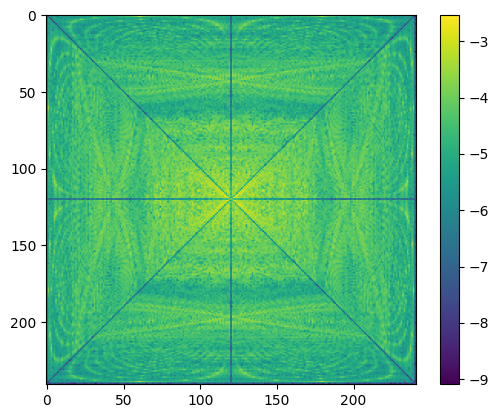

In [147]:
plt.imshow(np.log10(np.abs(true_Id - res)))
plt.colorbar()

In [148]:
%timeit ultimate_onion_peeling(hori, vert, toeplitz_list, nufft_list)

367 ms ± 11.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [149]:
%timeit fast_onion_peeling(hori, vert)

8.44 s ± 72.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
